## Q1
We sample data ($x$) from a normal($\theta$ = 4, $\tau$ = 0.25) distribution. We use $N(\theta_0 = 3, \tau_0 = 3)$ and $Gamma(\alpha = \frac{3}{2}, \lambda = \frac{3}{2})$ as priors/proposals for $\theta$ and $\tau$, respectively.\
Our Gibbs sampler from last week takes advantage of the Normal-Gamma model to analytically determine full conditional distributions $p(\theta|x,\tau)$ and $p(\tau|x, \theta)$, sample from them, and estimate $\theta$ and $\tau$ from these samples.
Using Metropolis-Hastings (MH), we can forgo determining how to update the full conditional distributions and estimate $\theta$ and $\tau$ by coming up with guesses for these variables and either accepting or rejecting them based on the probability that they appear in a posterior-like target distribution for $\theta$ and $\tau$. \
The differences between these sampling techniques is displayed as we change the shape parameter ($\alpha$) in the Gamma prior for $\tau$. A high $\alpha$ increases the mean and variance of the Gamma prior. In the Gibbs sampler, this decreases the influence of $\theta$'s prior on its posterior and possibly helping the estimates for $\theta$ converge quicker, as discussed last week. In the MH (within Gibbs) sampler, this increase in variance can similarly help the rate of convergence by increasing the effective sampple size. However, a variance that is too high will increase the dependence among MH samples because a larger proportion of our proposed values will be rejected (since they may have low density on the target distribution). This is displayed in the 3rd and 4th rows of graphs; when $\alpha = 10$, the $\tau$ estimate has just started to converge after staying with the initalization value of 1 for almost 100 iterations and the 95% credible interval for $\theta$ seems to be widening, all due to the high spread of values being proposed. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# loc is mean and scale is standard deviation
np.random.seed(365)
max_size = 100
m = 4; s = 2; x = stats.norm(loc=m, scale=s).rvs(size=max_size) 
print("data mean:", x.mean())
print("data precision:", 1/x.std()**2)
alphas = [0.1, 3, 10]; ldas = [0.1, 3, 10]
theta0s = [0.1, 3, 10]; tau0s = [0.1, 3, 10]
C,G = 1,5000  # chains, Gibbs samples
def MHGibbsSample(n = max_size, alpha = alphas[1], lda = ldas[1], theta0 = theta0s[1], tau0 = tau0s[1], C = C, G = G, m = m, s = s, x_t = x):
    x = x_t
    theta,tau = np.ones([C,G]),np.ones([C,G])
    theta_MH,tau_MH = np.ones([C,G]),np.ones([C,G])
    tau_target = lambda tau_: np.prod(stats.norm(loc=theta_MH[c,g-1], scale = 1/(tau_)**0.5).pdf(x)) *\
                                        stats.gamma(a = alpha/2, scale = 2/lda).pdf(tau_)
    tau_proposal = stats.gamma(a = alpha/2, scale = 2/lda)
    theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale = 1/(tau_MH[c,g])**0.5).pdf(x)) *\
                                                stats.norm(loc = theta0, scale = 1/tau0**0.5).pdf(theta_)
    theta_proposal = stats.norm(loc = theta0, scale = 1/tau0**0.5)
    for c in range(C):
        for g in range(1,G):
            tau[c,g] = stats.gamma(a = (n+alpha)/2, scale = 2/(lda + sum((theta[c, g - 1] - x)**2))).rvs(1)#\
            theta[c,g] = stats.norm((sum(x)*tau[c,g]+theta0*tau0)/(n*tau[c,g] + tau0), 1/(n*tau[c,g] +tau0)**0.5).rvs(1)#\
    
    
            # gamma(alpha/2, lambda/2) is prior for tau
            # as func of tau, likelihood*prior of tau is prop to joint, prior for theta is irrelevant
            
            
            tau_tilde = tau_proposal.rvs()
            mh_calc = tau_target(tau_tilde)/tau_target(tau_MH[c,g-1])*\
                                  (tau_proposal.pdf(tau_MH[c,g-1]))/(tau_proposal.pdf(tau_tilde))
            acc_prob = min(1, mh_calc)
            if stats.uniform().rvs() < acc_prob:
                tau_MH[c,g] = tau_tilde
            else:
                tau_MH[c,g] = tau_MH[c,g-1]  

            # N(theta0, tau0) is prior for theta
            # as func of tau, likelihood*prior of tau is prop to joint, prior for theta is irrelevant
            
            theta_tilde = theta_proposal.rvs()
            mh_calc = theta_target(theta_tilde)/theta_target(theta_MH[c,g-1])*\
                        (theta_proposal.pdf(theta_MH[c,g-1]))/(theta_proposal.pdf(theta_tilde))
            acc_prob = min(1, mh_calc)
            if stats.uniform().rvs() < acc_prob:
                theta_MH[c,g] = theta_tilde
            else:
                theta_MH[c,g] = theta_MH[c,g-1] 
            
    return theta, tau, theta_MH, tau_MH
burn = 20
thas, tus, thasMH, tusMH = np.zeros([len(alphas),G]), np.zeros([len(alphas),G]),np.zeros([len(alphas),G]), np.zeros([len(alphas),G])
tha_CI = np.zeros([len(alphas),G], dtype=object)
thaMH_CI  = np.zeros([len(alphas),G], dtype=object) 
tu_CI = np.zeros([len(alphas),G], dtype=object)
tuMH_CI = np.zeros([len(alphas),G], dtype=object)
for a in range(len(alphas)):
    samp_tha, samp_tu, samp_thaMH, samp_tuMH = MHGibbsSample(alpha = alphas[a])
    for n in range(burn, G):
        thas[a, n], thasMH[a, n] = np.mean(samp_tha[0,burn-1:n]), np.mean(samp_thaMH[0,burn-1:n])
        tus[a, n], tusMH[a, n] = np.mean(samp_tu[0,burn-1:n]), np.mean(samp_tuMH[0,burn-1:n])
        tha_CI[a, n] = tuple(np.quantile(samp_tha[0,burn-1:n], [0.025, 0.975]))
        thaMH_CI[a, n] = tuple(np.quantile(samp_thaMH[0,burn-1:n], [0.025, 0.975]))
        tu_CI[a, n] = tuple(np.quantile(samp_tu[0,burn-1:n], [0.025, 0.975]))
        tuMH_CI[a, n] = tuple(np.quantile(samp_tuMH[0,burn-1:n], [0.025, 0.975]))

data mean: 3.875705961736949
data precision: 0.266395467649666


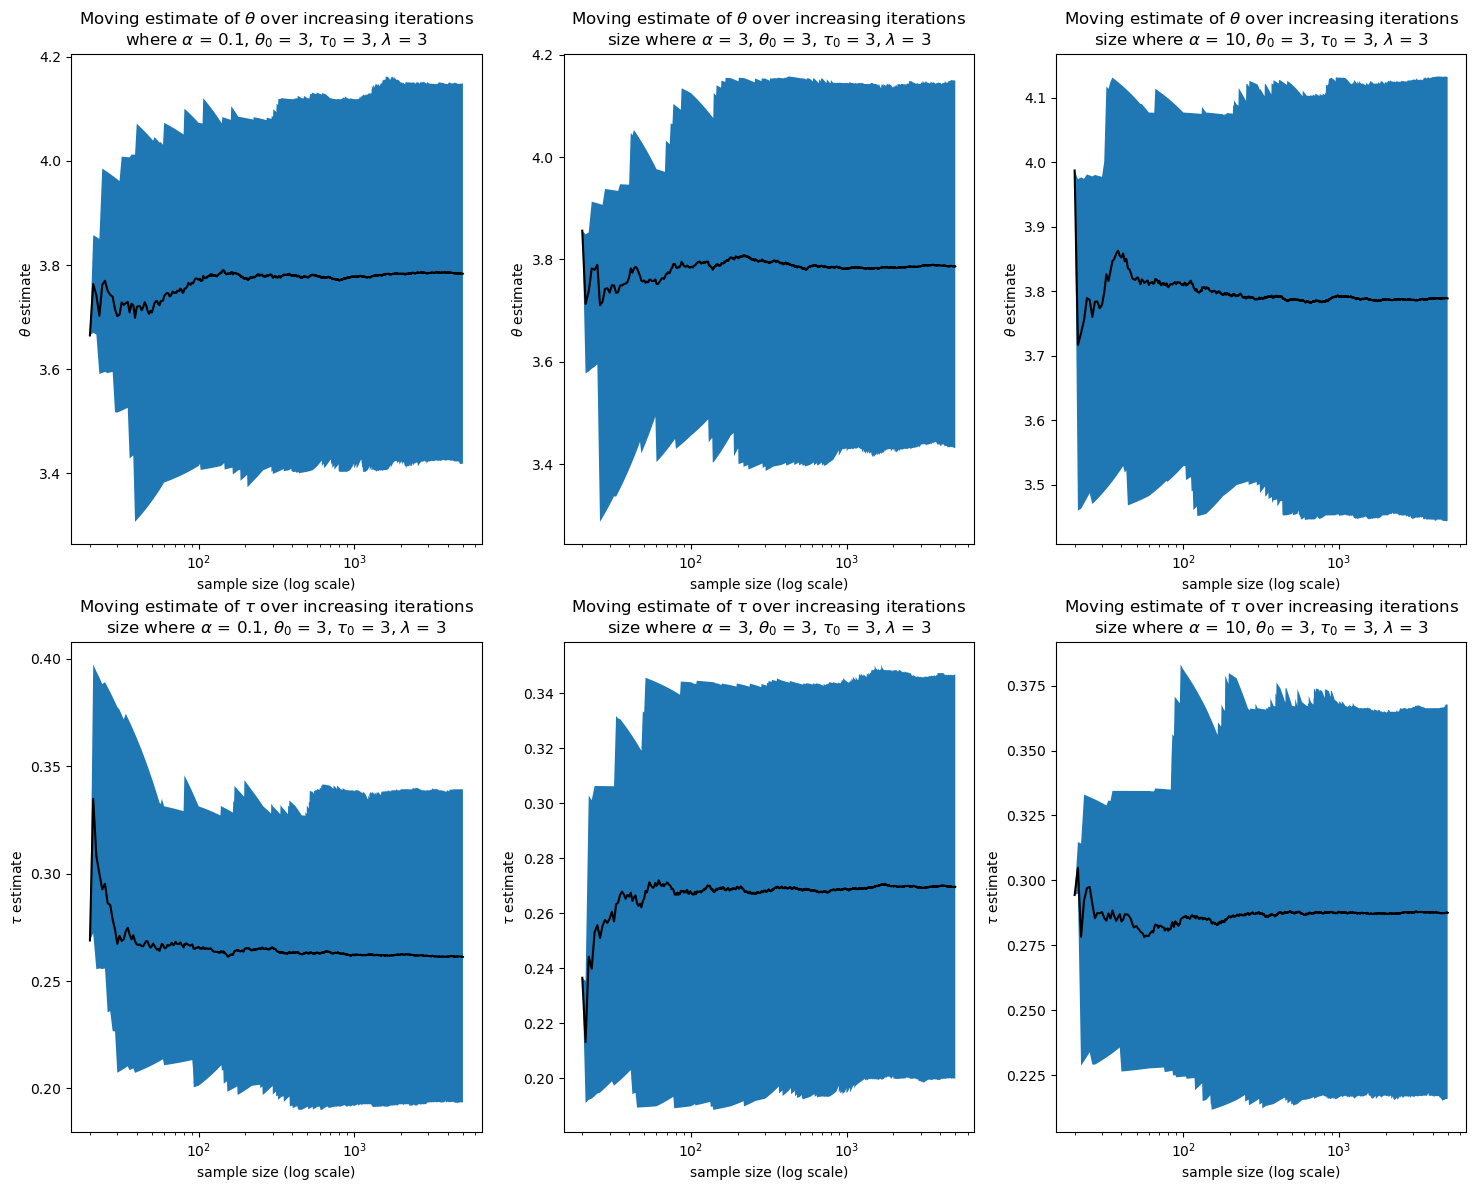

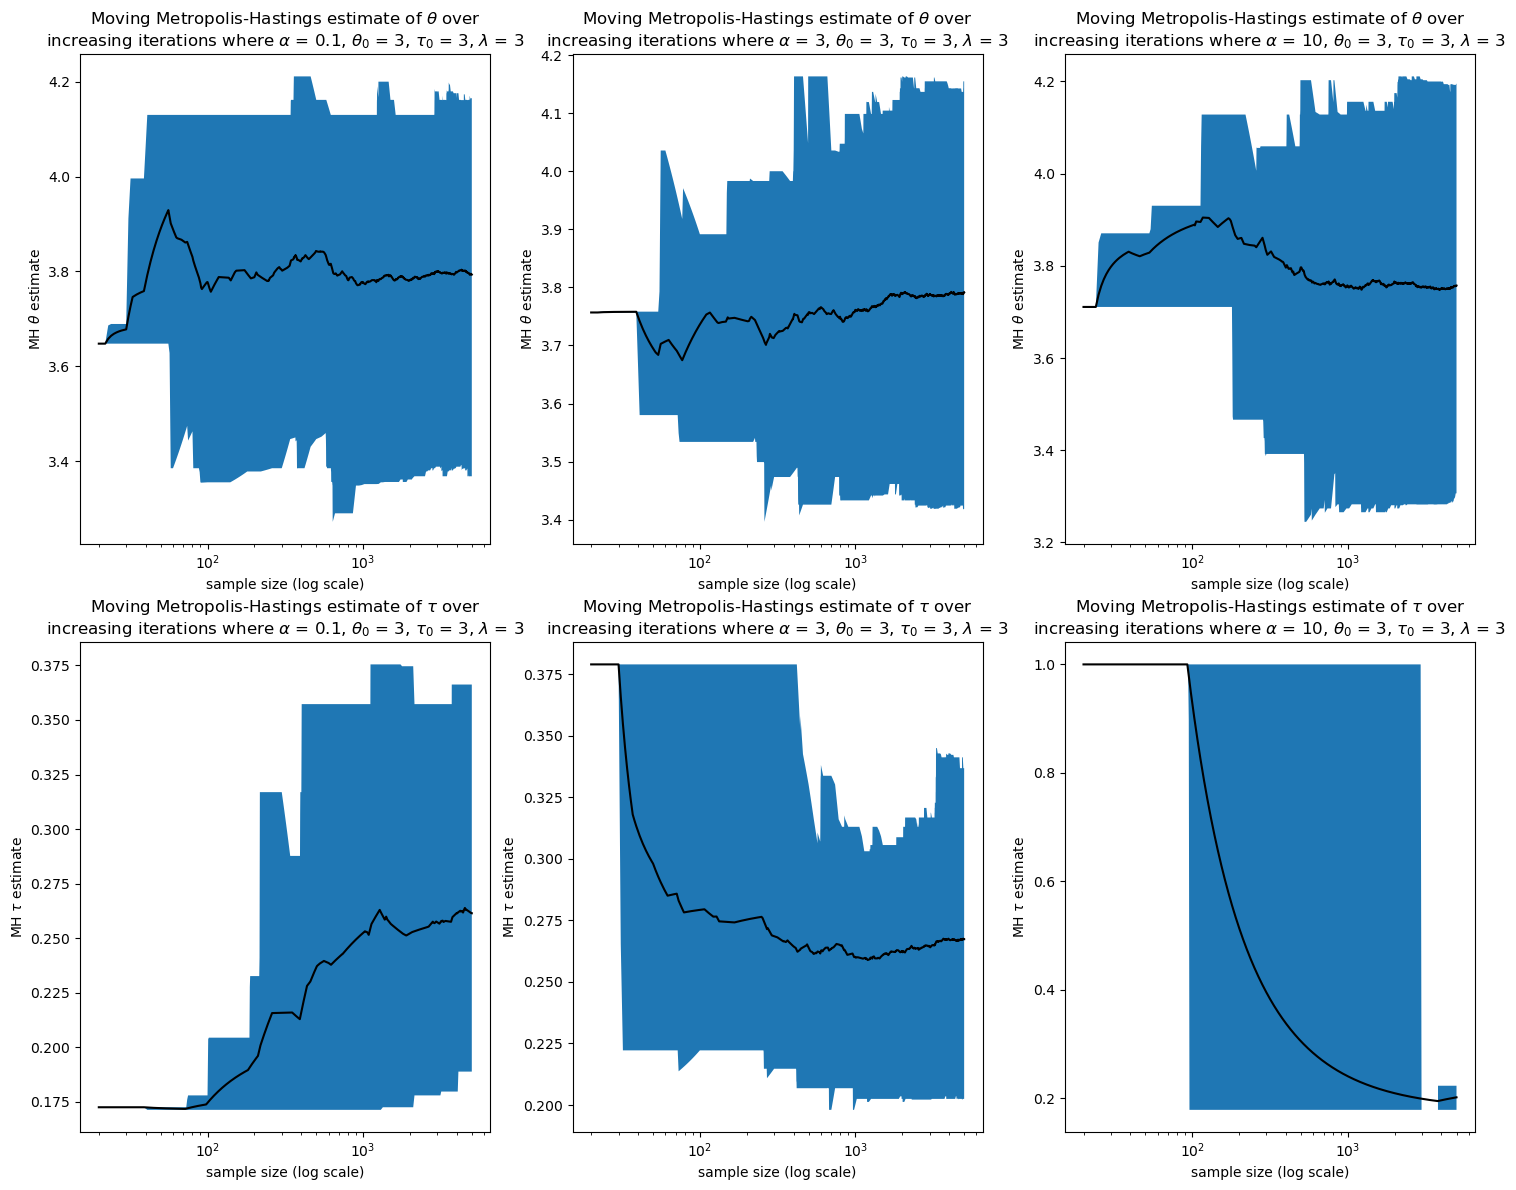

In [6]:
fig,ax = plt.subplots(2, 3, figsize=(18,14)); 
ax[0,0].set_title(("Moving estimate of $\\theta$ over increasing iterations\nwhere $\\alpha$ = " + str(alphas[0]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[0,1].set_title(("Moving estimate of $\\theta$ over increasing iterations\nsize where $\\alpha$ = " + str(alphas[1]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[0,2].set_title(("Moving estimate of $\\theta$ over increasing iterations\nsize where $\\alpha$ = " + str(alphas[2]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[1,0].set_title(("Moving estimate of $\\tau$ over increasing iterations\nsize where $\\alpha$ = " + str(alphas[0]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[1,1].set_title(("Moving estimate of $\\tau$ over increasing iterations\nsize where $\\alpha$ = " + str(alphas[1]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[1,2].set_title(("Moving estimate of $\\tau$ over increasing iterations\nsize where $\\alpha$ = " + str(alphas[2]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
#print([x for x in tha_CI[c,burn:60]])
for c in range(3):
    ax[0, c].plot(range(burn,G), thas[c,burn:], 'k-')
    lowerCI = [x[0] for x in tha_CI[c,burn:]]
    upperCI = [x[1] for x in tha_CI[c,burn:]]
    ax[0, c].fill_between(range(burn,G), lowerCI, upperCI)  
    ax[0, c].set_xlabel("sample size (log scale)")
    ax[0, c].set_ylabel("$\\theta$ estimate")
    ax[0,c].set_xscale('log')
for c in range(3):
    ax[1, c].plot(range(burn,G), tus[c,burn:], 'k-')
    lowerCI = [x[0] for x in tu_CI[c,burn:]]
    upperCI = [x[1] for x in tu_CI[c,burn:]]
    ax[1, c].fill_between(range(burn,G), lowerCI, upperCI) 
    ax[1, c].set_xlabel("sample size (log scale)")
    ax[1, c].set_ylabel("$\\tau$ estimate")
    ax[1,c].set_xscale('log')
fig,ax = plt.subplots(2, 3, figsize=(18,14)); 
ax[0,0].set_title(("Moving Metropolis-Hastings estimate of $\\theta$ over\nincreasing iterations where $\\alpha$ = " + str(alphas[0]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[0,1].set_title(("Moving Metropolis-Hastings estimate of $\\theta$ over\nincreasing iterations where $\\alpha$ = " + str(alphas[1]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[0,2].set_title(("Moving Metropolis-Hastings estimate of $\\theta$ over\nincreasing iterations where $\\alpha$ = " + str(alphas[2]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[1,0].set_title(("Moving Metropolis-Hastings estimate of $\\tau$ over\nincreasing iterations where $\\alpha$ = " + str(alphas[0]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[1,1].set_title(("Moving Metropolis-Hastings estimate of $\\tau$ over\nincreasing iterations where $\\alpha$ = " + str(alphas[1]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
ax[1,2].set_title(("Moving Metropolis-Hastings estimate of $\\tau$ over\nincreasing iterations where $\\alpha$ = " + str(alphas[2]) +", $\\theta_0$ = "+ str(theta0s[1]) +", $\\tau_0$ = "+ str(tau0s[1])+", $\\lambda$ = "+str(ldas[1])))
for c in range(3):
    ax[0, c].plot(range(burn,G), thasMH[c,burn:], 'k-')
    lowerCI = [x[0] for x in thaMH_CI[c,burn:]]
    upperCI = [x[1] for x in thaMH_CI[c,burn:]]
    ax[0, c].fill_between(range(burn,G), lowerCI, upperCI)  
    ax[0, c].set_xlabel("sample size (log scale)")
    ax[0, c].set_ylabel("MH $\\theta$ estimate")
    ax[0,c].set_xscale('log')
for c in range(3):
    ax[1, c].plot(range(burn,G), tusMH[c,burn:], 'k-')
    lowerCI = [x[0] for x in tuMH_CI[c,burn:]]
    upperCI = [x[1] for x in tuMH_CI[c,burn:]]
    ax[1, c].fill_between(range(burn,G), lowerCI, upperCI) 
    ax[1, c].set_xlabel("sample size (log scale)")
    ax[1, c].set_ylabel("MH $\\tau$ estimate")
    ax[1,c].set_xscale('log')            

data mean: 4.994996328178437
data precision: 1.3742549788102913
theta estimate:  5.0
theta 95% Credible Interval:  [5. 5.]
tau estimate:  1.3460721379845573
tau 95% Credible Interval:  [0.779842   2.08520659]


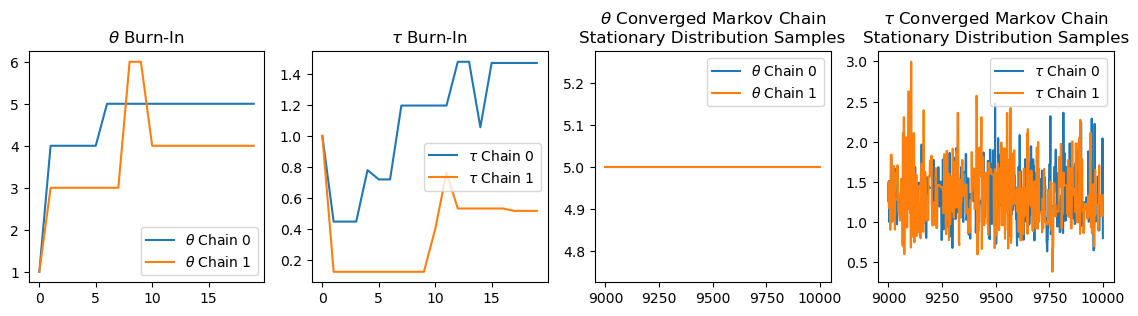

In [42]:
#Q2
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(365)
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=5, scale=1).rvs(size=n) #normal target
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1  # initialization
tau[:,0] = 1
theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale = 1/(tau[c,g])**0.5).pdf(x)) * stats.geom(p = 0.8).pmf(theta_)
theta_proposal = stats.boltzmann(lambda_ = 0.01, N = 9)
tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1], scale = 1/(tau_)**0.5).pdf(x)) *\
                                    stats.expon(scale = 1).pdf(tau_)
tau_proposal = stats.truncnorm(a=-tau[c,g-1]/1, b=np.Inf, loc=tau[c,g-1], scale=1)
for c in range(C):
    for g in range(1,G):
        
        # expon is prior for tau
        # as func of tau, likelihood*prior of tau is prop to joint, prior for theta is irrelevant
        tau_tilde = tau_proposal.rvs()
        mh_calc = tau_target(tau_tilde)/tau_target(tau[c,g-1])*\
                              (tau_proposal.pdf(tau[c,g-1]))/(tau_proposal.pdf(tau_tilde))
        acc_prob = min(1, mh_calc)
        if stats.uniform().rvs() < acc_prob:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]  
        
        #fill in theta
        # geom is prior for theta
        theta_tilde = theta_proposal.rvs()
        mh_calc = theta_target(theta_tilde)/theta_target(theta[c,g-1])*(theta_proposal.pmf(theta[c,g-1]))/(theta_proposal.pmf(theta_tilde))
        acc_prob = min(1, mh_calc)
        if stats.uniform().rvs() < acc_prob:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]  

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); 
ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); 
ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo_start = 9000
demo_end = 10000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(demo_start,demo_end, dtype=int), theta[c,demo_start:demo_end], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(demo_start, demo_end, dtype=int), tau[c,demo_start:demo_end], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         
print("data mean:", x.mean())
print("data precision:", 1/x.std()**2)
print("theta estimate: ", theta[0][burn:].mean())
print("theta 95% Credible Interval: ", np.quantile(theta[0][burn:], [0.025, 0.975]))
print("tau estimate: ", tau[0][burn:].mean())
print("tau 95% Credible Interval: ", np.quantile(tau[0][burn:], [0.025, 0.975]))

I don't know anything about the Boltzman pmf, the truncated noraml pdf, and their relationship to my chosen Exponential and Geometric priors, but that can't stop me from using them as proposal distributions in a MH sampler. This is because in MH we only care about how probable our current state is compared to the proposed state (conditioned on the data), so there isn't any need to determine the posterior distribution "update rule", like in traditonal Gibbs sampling.

## Q3
$\Pr(x^{(t-1)}=0 \rightarrow x^{(t)}=0) = \Pr(\tilde{x}^{(t)} = 0) + \Pr(reject\ \tilde{x}^{(t)} = 1) \\ 
= q(\tilde{x}^{(t)} = 0 | {x}^{(t-1)} = 0) + q(\tilde{x}^{(t)} = 1 | \tilde{x}^{(t-1)} = 0)(1 - \min\{\frac{p(\tilde{x}^{(t)} = 1)}{p({x}^{(t-1)} = 0)}\frac{q({x}^{(t-1)} = 0 | \tilde{x}^{(t)} = 1)}{q(\tilde{x}^{(t)} = 1 | {x}^{(t)} = 0)}, 1\}) = \frac{1}{2} + \frac{1}{2}(1 - \min\{\frac{\frac{2}{3}}{\frac{1}{3}}\frac{\frac{1}{2}}{\frac{1}{2}}, 1\}) = 0.5$
We also can now see that $\frac{q({x}^{(t-1)}| \tilde{x}^{(t)})}{q(\tilde{x}^{(t)}| {x}^{(t)})} = 1$, always (since it is independent of the given data and the masses at $\tilde{x}^{(t)} = 1$ and $\tilde{x}^{(t)} = 0$ are both 0.5).
$\Pr(x^{(t-1)}=0 \rightarrow x^{(t)}=1) = \Pr(accept\ \tilde{x}^{(t)} = 1) \\
= q(\tilde{x}^{(t)} = 1 | {x}^{(t-1)} = 0)(\min\{\frac{p(\tilde{x}^{(t)} = 1)}{p({x}^{(t-1)} = 0)},1\}) = \frac{1}{2}\min\{\frac{\frac{2}{3}}{\frac{1}{3}}, 1\} = 0.5$

$\Pr(x^{(t-1)}=1 \rightarrow x^{(t)}=0) = \Pr(accept\ \tilde{x}^{(t)} = 0) \\
= q(\tilde{x}^{(t)} = 0 | {x}^{(t-1)} = 1)(\min\{\frac{p(\tilde{x}^{(t)} = 0)}{p({x}^{(t-1)} = 1)},1\}) = \frac{1}{2}\min\{\frac{\frac{1}{3}}{\frac{2}{3}}, 1\} = 0.25$

$\Pr(x^{(t-1)}=1 \rightarrow x^{(t)}=1) = \Pr(\tilde{x}^{(t)} = 1) + \Pr(reject\ \tilde{x}^{(t)} = 0) \\
= q(\tilde{x}^{(t)} = 1 | {x}^{(t-1)} = 1) + q(\tilde{x}^{(t)} = 0 | \tilde{x}^{(t-1)} = 1)(1 - \min\{\frac{p(\tilde{x}^{(t)} = 0)}{p({x}^{(t-1)} = 1)}, 1\}) = \frac{1}{2} + \frac{1}{2}(1 - \min\{\frac{\frac{1}{3}}{\frac{2}{3}},1\}) = 0.75$\
Therefore the transition kernel is:\
$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$